In [5]:
%matplotlib inline

In [14]:
pwd

'/Users/peterhaglich/Dropbox/Work/IARPA/HFC/gfc/gfc/src/notebooks'

In [199]:
import matplotlib
matplotlib.style.use("seaborn-dark")
import os
import json
import re
from pprint import pprint
import numpy as np
import pandas as pd
import warnings
GFC_HOME = os.path.abspath("../..")
auth_file_path = os.path.join(GFC_HOME, "src", "resources", "auth.json")
with open(os.path.join(GFC_HOME, auth_file_path), "r") as f:
    api_key_dict = json.load(f)

# Some Useful External Data Sources for GFC 2

In this notebook we provide some example Python code for accessing external data sources that may be relevant to some of the Challenge IFPs.  Please note that we make no guarantee that these sources will have predictive power for any of the IFPs.  However, they may provide a launching point for Solvers to access external data relevant to the IFPs.  In some cases these sources will be the resolution criteria for the IFPs.

Solvers are responsible for complying with all terms of use for the data sources they access.  All code in this document is provided using the [CC0 1.0 Universal (CC0 1.0) Public Domain Dedication](https://creativecommons.org/publicdomain/zero/1.0/).  The examples have been tested using Python 3 but have not been tested under Python 2.

## [Quandl](https://www.quandl.com)

Quandl provides a large number of time series for financial data.  A great deal of this content is free while other content requires paid premium access.  The examples here will only address the free data.

Programmatic access to Quandl's API is available for Python, R, and Excel but requires a free API key.  See the [Quandl API documentation](https://docs.quandl.com) for details on obtaining this key and other API documentation.  To use your API key just issue a simple command

`quandl.ApiConfig.api_key = "YOURAPIKEY"`, replacing `YOURAPIKEY` with your actual key.

In [18]:
QUANDL_KEY = api_key_dict["quandl"]

In [19]:
import quandl
quandl.ApiConfig.api_key = QUANDL_KEY

The basic statement to access data is `quandl.get("QUANDL_CODE")`, where `QUANDL_CODE` is Quandl's identifier for the time series and can be found by searching https://www.quandl.com/search

### Example: Gold Prices

GF Challenge 1 had IFPs related to predicting the future price of gold from the London Bullion Market Association..  In this example we will show the use of the Quandl API to get the historical price of that time series.  The Quandl identifier is `LBMA/GOLD`.  Let's retrieve and examine the tail of the data.

In [20]:
gold = quandl.get("LBMA/GOLD")
gold.tail()

,USD (AM),USD (PM),GBP (AM),GBP (PM),EURO (AM),EURO (PM)
Date,,,,,,
2019-04-02,1287.20,1290.30,984.97,988.37,1148.95,1151.59
2019-04-03,1291.85,1290.45,980.38,981.26,1148.84,1147.98
2019-04-04,1291.60,1283.15,981.87,978.66,1149.78,1144.18
2019-04-05,1288.90,1288.45,985.11,989.53,1147.51,1148.01
2019-04-08,1297.10,1300.00,993.58,996.45,1154.29,1153.49


The returned value is a pandas Data Frame object with 6 columns.  In previous IFPs the resolution time series was the column `USD (PM)`.  Let's look at a plot of this series.

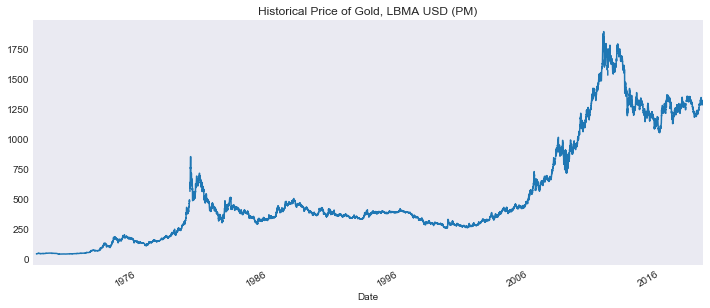

In [10]:
gold["USD (PM)"].plot(figsize=(12, 5), title="Historical Price of Gold, LBMA USD (PM)");

Now that the data is in a time series you can try any number of time series techniques such as ARIMA models or Recurrent Neural Networks.

## [STOXX](https://www.stoxx.com)

STOXX also provides indices for financial indices which are used in some IFPs.  STOXX doesn't have a programmating API so you'll need to use the Python `urllib` module to pull down the data.  The example below will walk through this.

### Example: VSTOXX

VSTOXX is the volatility of the Euro STOXX 50 index and has been the subject of IFPs in the past.  The historical data is available in textual format at https://www.stoxx.com/document/Indices/Current/HistoricalData/h_vstoxx.txt.  In the example we will use the `urllib` module to process this data into a pandas Data Frame.

In [12]:
import urllib3
from dateutil.parser import parse # To convert strings to timestamps
import pandas as pd
http = urllib3.PoolManager()
VSTOXX_URL = "https://www.stoxx.com/document/Indices/Current/HistoricalData/h_v2tx.txt"
r = http.request("GET", VSTOXX_URL)
raw_data = r.data.decode("utf-8")
_data = raw_data.split("\n") # Splitting into separate lines.
_data = [row.split(";") for row in _data] # Splitting each line into columns
_columns = _data[0] # The first row holds the names for the data frame columns
_data = [{"Date": parse("-".join(row[0].split(".")), dayfirst=True),
          "Indexvalue": float(row[2])}
         for row in _data[1:-1]]  # Process each row into a dict, creating timestamps and floating values.
print("There are {} rows in the data".format(len(_data)))
v2tx_df = pd.DataFrame(_data)
v2tx_df.set_index(v2tx_df.columns[0], inplace=True, verify_integrity=True) # Converting to a time indexed dataframe with one column
v2tx_df.tail()

/Users/peterhaglich/anaconda/envs/hfc/lib/python3.5/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


There are 5158 rows in the data


,Indexvalue
Date,
2019-04-02,14.7848
2019-04-03,14.1923
2019-04-04,14.2468
2019-04-05,13.5520
2019-04-08,14.6030


The historical time series for the VSTOXX data is shown below.  As with the Quandl data we now have a time series that we can apply modeling techniques to.

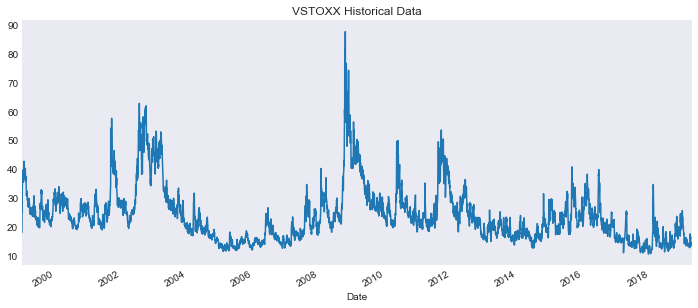

In [13]:
v2tx_df["Indexvalue"].plot(figsize=(12,5), title="VSTOXX Historical Data");

## [US Energy Information Administration](https://www.eia.gov/)
The US Energy Information Administration (EIA) provides open data related to energy production and use for electricity, petroleum, and natural gas.  They provide a REST API that can be queried for this data, with documentation at https://www.eia.gov/opendata/commands.php.  A free API Key is required and can be obtained from EIA.

### Example: Oil Production in Algeria

The query URL for EIA is of the form `http://api.eia.gov/series/?api_key=API_KEY&series_id=SERIES_ID`.  To find the series ID for the country of interest, go to https://www.eia.gov/totalenergy/data/browser/?tbl=T11.01A#/?f=M&start=197301&end=201507&charted=12 and select the country desired.  The next page will include the data.  

The returned result is a bytes object which encapsulates a string which in turn encapsulates a dict structure.  The code below pulls the data and converts it to a dict.

In [34]:
eia_key = api_key_dict["eia"]
EIA_URL = "http://api.eia.gov"
series_id = "TOTAL.PAPRPAG.M"
query_url = EIA_URL + "/series/?api_key={}&series_id={}".format(eia_key, series_id)
r = http.request("GET", query_url)
raw_data = eval(r.data.decode()) # Decode turns bytes to string, eval converts to dict
print(raw_data.keys())

dict_keys(['request', 'series'])


The data of interest is in the `series` field, which is a list of one item, which is itself a dict.  Let's look at the structure:

In [71]:
_data = raw_data["series"][0]
print(_data.keys())

dict_keys(['series_id', 'units', 'start', 'updated', 'data', 'name', 'end', 'f'])


The time series data is contained in the `data` element.  Other fields provide metadata such as start and end dates, frequency, and units.  For our data, it looks like this:

In [72]:
print(_data["data"][:4]) # Last 4 data items
print(_data["units"]) # Units of measure
print(_data["f"]) # Frequency, M = monthly

[['201812', 1242], ['201811', 1242], ['201810', 1242], ['201809', 1242]]
Thousand Barrels per Day
M


Individual data points for this series are of the format YYYYMM and newest elements are earliest in the list.  We will need to convert the string to dates.

In [73]:
_data = _data["data"]
_data =[(parse(x[0]+"01"), x[1]) for x in _data]
_ser = pd.Series([x[1] for x in _data], index=[x[0] for x in _data])
_ser = _ser.sort_index(ascending=True) # Underlying data is in reverse time order, so we need to sort.
_ser.head()

1973-01-01    1142.0
1973-02-01    1142.0
1973-03-01    1142.0
1973-04-01    1142.0
1973-05-01    1153.0
dtype: float64

After processing the data the monthly production series is shown below.

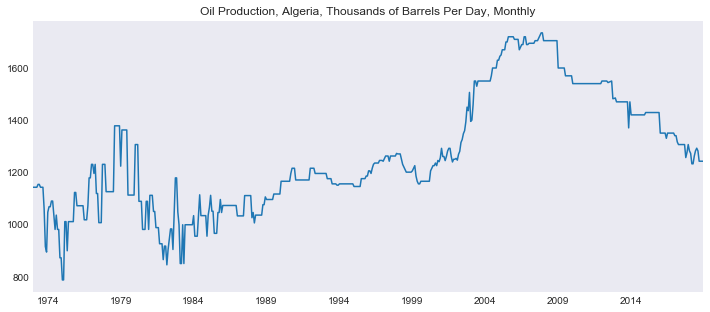

In [69]:
_ser.plot(figsize=(12,5), title="Oil Production, Algeria, Thousands of Barrels Per Day, Monthly");

## [eurostat](https://ec.europa.eu)

eurostat provides a great deal of statistical information about the countries of the European Union.  It provides a REST API which is documented at https://ec.europa.eu/eurostat/web/json-and-unicode-web-services/about-this-service.

### Example: Austrian Unemployment Data from eurostat
The example below will illustrate building a query, using `urllib3` to send the request, and processing the JSON return.  Each dataset has an identifier which can be found be browsing https://ec.europa.eu/eurostat/data/database.  For the unemployment data this is "teilm020".   The `geo` field is used to identify which countries are to be queried.  The best way to find those codes is to use their [query builder](https://ec.europa.eu/eurostat/web/json-and-unicode-web-services/getting-started/query-builder) and make a few selections to look at the resulting queries.  The code for Austria is "AT".  Putting it together:

In [135]:
EUROSTAT_URL_BASE = "http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/"
DATASET_ID = "teilm020"
PRECISION_FILLER = "?precision=1"
GEO_ID = "AT"
query_url = EUROSTAT_URL_BASE + DATASET_ID + PRECISION_FILLER + "&geo={}".format(GEO_ID)
print("Our query URL is {}".format(query_url))
r = http.request("GET", query_url)
raw_data = r.data.decode()  # This produces a bytes object, we need to decode it to a string
print(raw_data)

Our query URL is http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/teilm020?precision=1&geo=AT
{"version":"2.0","label":"Harmonised unemployment rate by sex","href":"http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/teilm020?precision=1&geo=AT","source":"Eurostat","updated":"2019-04-02","status":{"11":":","23":":","35":":"},"extension":{"datasetId":"teilm020","lang":"EN","description":"The unemployment rate represents unemployed persons as a percentage of the labour force based on International Labour Office (ILO) definition. The labour force is the total number of people employed and unemployed. Unemployed persons comprise persons aged 15 to 74 who:<br />- are without work during the reference week; <br />- are available to start work within the next two weeks; <br />- and have been actively seeking work in the past four weeks or had already found a job to start within the next three months. <br />Data are presented in seasonally adjusted form.","subTitle":null,"status":

With the EIA data above we just used the `eval` command to turn the string into a dict.  Let's try it below....

In [137]:
eval(raw_data)

NameError: name 'null' is not defined

That doesn't work.  The problem is a value of `null` for subTitle that isn't enclosed in quotes, so Python doesn't know what to do with it.  Let's try to fix it using a regex string substitution:

In [139]:
raw_data = re.sub("null", "\"null\"", raw_data)
_data = eval(raw_data)
pprint(_data)

{'class': 'dataset',
 'dimension': {'age': {'category': {'index': {'TOTAL': 0},
                                    'label': {'TOTAL': 'Total'}},
                       'label': 'age'},
               'geo': {'category': {'index': {'AT': 0},
                                    'label': {'AT': 'Austria'}},
                       'label': 'geo'},
               's_adj': {'category': {'index': {'SA': 0},
                                      'label': {'SA': 'Seasonally adjusted '
                                                      'data, not calendar '
                                                      'adjusted data'}},
                         'label': 's_adj'},
               'sex': {'category': {'index': {'F': 0, 'M': 1, 'T': 2},
                                    'label': {'F': 'Females',
                                              'M': 'Males',
                                              'T': 'Total'}},
                       'label': 'sex'},
               'time': {'categ

It's a bit confusing.  The elements of the `value` field look like the numbers that we want but there seem to be too many of them, considering that our time index only has 12 entries.  The reason for this can be found in the `category` field where we see that the data is broken out by females, males, and total.  Articulating the values to categories is non-intuitive.  I had to look at the [eurostat table layout for this data](https://ec.europa.eu/eurostat/data/database?p_p_id=NavTreeportletprod_WAR_NavTreeportletprod_INSTANCE_nPqeVbPXRmWQ&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view&p_p_col_id=column-2&p_p_col_pos=1&p_p_col_count=2) in order to figure out which values correspond to which categories.  The values with indices 0 through 11 belong to the females, 12 through 23 to males, 24 to 35 for total.  Notice that there are no values given for indices 11, 23, or 35.  An inspection of the table layout shows that at the time I accessed the data the last month was missing.  OK, armed with this knowledge, let's try to make a data frame out of this data.  First, we need to convert the string formatted integer keys in the `value` field to actual integers:

In [143]:
_values = _data["value"]
_values = {int(k):v for k,v in _values.items()} # Keys are now integers

Now we need to insert "NA" values for missing elements.  To identify which items are missing we need to figure out how many we have.  That's the product of the number of categories and the length of the index.  Thankfully, the data has a `size` field that tells us the number of items along each dimension.  We just need to multiply so see how many we have:

In [151]:
dim = _data["size"]
prod = 1
for d in dim:
    prod = prod*d
print("There should be {} values.".format(prod))

There should be 36 values.


Lets put placeholders in our `_values` dict and convert to a pandas Series

In [154]:
for k in range(prod):
    if k not in _values.keys():
        _values[k] = np.nan
value_ser = pd.Series(_values)

We are going to create a tidy dataframe with variables in columns and each row representing a record.  Our dataframe will look something like:

    time    gender    value
0   2018M04    F        4.6

...

12  2018M04    M        4.9

...

34  2019M02    T        5.0

35  2019M03    T        NaN

The time column will just be the time index, repeated.  We'll grab the length of the time index for later use.

In [161]:
time_index = sorted(list(_data["dimension"]["time"]["category"]["index"].keys()))
n_periods = len(time_index)
time_index = 3*time_index
time_index_ser = pd.Series(time_index)

The Gender column will be 12 "F", 12 "M", 12 "T"  We could pull it out programmatically by parsing the fields and sorting them but it's easy enough to hard code:

In [163]:
genders = n_periods*["F"] + n_periods*["M"] + n_periods*["T"]
gender_ser = pd.Series(genders)

Putting it all together gives us this dataframe:

In [165]:
eurostat_df = pd.DataFrame({"month": time_index_ser,
                            "gender": gender_ser,
                            "value": value_ser})
eurostat_df.head()

,gender,month,value
0,F,2018M04,4.6
1,F,2018M05,4.5
2,F,2018M06,4.5
3,F,2018M07,4.8
4,F,2018M08,5.1


Suppose that we want to plot the trend in total unemployment.  We could parse the month column to get timestamps but we can see what we want without doing so:

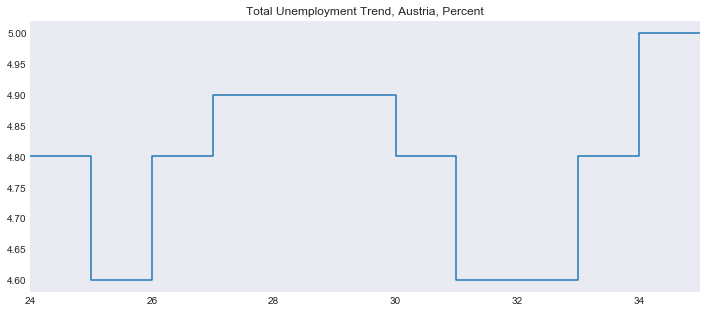

In [175]:
total_df = eurostat_df[eurostat_df.gender=="T"]
total_df["value"].plot(title="Total Unemployment Trend, Austria, Percent",
                       figsize=(12,5), drawstyle="steps-post");

## USGS Earthquake Data
In the first GF Challenge there were some IFPs for forecasting the number of earthquakes of a certain magnitude during a certain interval.  USGS does provide a [REST API](https://earthquake.usgs.gov/fdsnws/event/1/) that will respond to queries like this and will provide output in a number of formats such as KML or GeoJSON.

### Example: Earthquake Counts Magnitude 5 or Higher
The example below constructs a query for the number of worldwide earthquakes magnitude 5 or higher between March 1 and March 31, 2019, worldwide:

In [189]:
#query_url = EUROSTAT_URL_BASE + DATASET_ID + PRECISION_FILLER + "&geo={}".format(GEO_ID)
query_url_base = "https://earthquake.usgs.gov/fdsnws/event/1/count"
return_format = "geojson"
starttime = "2019-03-01"  # YYYY-MM-DD
endtime = "2019-03-31"
min_magnitude = 5
query_url = query_url_base + "?format={}&starttime={}&endtime={}&minmagnitude={}".format(return_format, starttime, endtime, min_magnitude)
print("Our query URL is {}".format(query_url))
r = http.request("GET", query_url)
raw_data = r.data.decode()  # This produces a bytes object, we need to decode it to a string
print(raw_data)

Our query URL is https://earthquake.usgs.gov/fdsnws/event/1/count?format=geojson&starttime=2019-03-01&endtime=2019-03-31&minmagnitude=5


/Users/peterhaglich/anaconda/envs/hfc/lib/python3.5/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


{"count":125,"maxAllowed":20000}


To convert it to a dict use the `eval` statement:

In [188]:
_data = eval(raw_data)
pprint(_data)

{'count': 125, 'maxAllowed': 20000}


Now suppose we wish to restrict our query to a specific region defined by minimum and maximum values for latitude and longitude.  We do this by specifying values for `minlatitude`, `maxlatitude`, ,`minlongitude`, `maxlongitude` and adding them to the query URL.  Let's look at a large bounding box centered on Japan.

In [190]:
min_lat, max_lat = (25, 45)
min_long, max_long = (125, 155)
query_url = query_url + "&minlatitude={}&maxlatitude={}&minlongitude={}&maxlongitude={}".format(min_lat, max_lat, min_long, max_long)
print("Our query URL is {}".format(query_url))
r = http.request("GET", query_url)
raw_data = r.data.decode()  # This produces a bytes object, we need to decode it to a string
print(raw_data)

Our query URL is https://earthquake.usgs.gov/fdsnws/event/1/count?format=geojson&starttime=2019-03-01&endtime=2019-03-31&minmagnitude=5&minlatitude=25&maxlatitude=45&minlongitude=125&maxlongitude=155
{"count":11,"maxAllowed":20000}


/Users/peterhaglich/anaconda/envs/hfc/lib/python3.5/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


The above is cumbersome, so we can define a function to run the query for us:

In [193]:
def get_quake_count(starttime, endtime, min_magnitude=0, bounding_box=dict()):
    """
    Retrieves earthquake count
    :param starttime: ISO 8601 Date/Time format, assumes UTC
    :param endtime: ISO 8601 Date/Time
    :min_magnitude: Earthquakes of this magnitude or higher."&minlatitude={}&maxlatitude={}&minlongitude={}&maxlongitude={}".format(min_lat, max_lat, min_long, max_long)
    :bounding_box: dict {"min_lat", "max_lat", "min_long", "max_long"}
    :returns: integer count
    """
    query_url_base = "https://earthquake.usgs.gov/fdsnws/event/1/count"
    return_format = "geojson"
    query_url = query_url_base + "?format=geojson"
    query_url += "&starttime={}&endtime={}&minmagnitude={}".format(starttime, endtime, min_magnitude)
    if bounding_box:
        query_url += "&minlatitude={}&maxlatitude={}&minlongitude={}&maxlongitude={}".format(bounding_box[min_lat], bounding_box[max_lat],
                                                                                             bounding_box[min_long], bounding_box[max_long])
    r = http.request("GET", query_url)
    raw_data = r.data.decode()  # This produces a bytes object, we need to decode it to a string
    _data = eval(raw_data)
    return _data["count"]
 

get_quake_count("2019-03-01", "2019-03-31", 5)

/Users/peterhaglich/anaconda/envs/hfc/lib/python3.5/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


125

Just for fun, let's look at the count of earthquakes by minimum magnitude for every .1 magnitude from 0 to 10.  I'll add a statement to repress the 100 warning messages regarding making requests of HTTPS without certificate verification.

In [203]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    m_values = [m/10 for m in range(101)]
    count_dict = {m: get_quake_count(starttime="2019-03-01", endtime="2019-03-31", min_magnitude=m)
                 for m in m_values}

The chart below shows the survival plot of earthquakes by magnitude, with the count on a logarithmic scale.

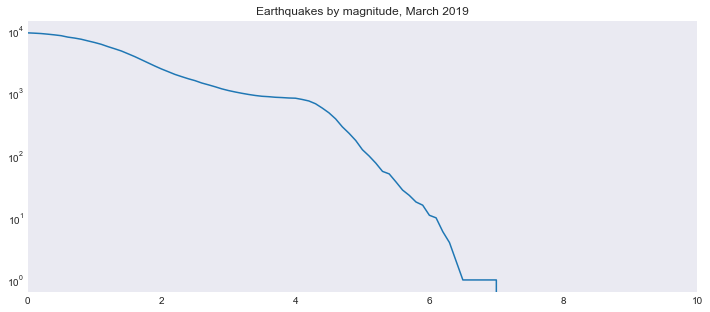

In [204]:
count_ser = pd.Series(count_dict)
count_ser.plot(figsize=(12,5), title="Earthquakes by magnitude, March 2019", logy=True);

## ACLED
Armed Conflict Location & Event Data Project (ACLED); acleddata.com

ACLED provides an API that is documented at https://www.acleddata.com/wp-content/uploads/dlm_uploads/2017/10/API-User-Guide.pdf.

ACLED queries return JSON by default but the user can specify other formats, such as CSV.

### Example: ACLED Battle Deaths in Yemen
In this example we will retrieve the battle deaths in Yemen for March 2019.  Every query must include the query parameter `terms=accept`.  Other query terms act as filters on what is searched and what is returned.  In our case we will set the country to Yemen, the event_type to Battle, and the dates to the range for March 2019.

In [249]:
acled_url = "https://api.acleddata.com/acled/read?terms=accept"
starttime = "2019-03-01"
endtime = "2019-03-31"
country = "yemen"
event_type = "battle"
query_url = acled_url + "&country={}".format(country)
query_url += "&event_type={}".format(event_type)
query_url += "&event_date={}|{}&event_date_where=BETWEEN".format(starttime, endtime)
query_url += "&field=iso|fatalities"
#query_url += "&export_type=csv"
print("Query URL: {}".format(query_url))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    r = http.request("GET", query_url)
raw_data = r.data.decode()

Query URL: https://api.acleddata.com/acled/read?terms=accept&country=yemen&event_type=battle&event_date=2019-03-01|2019-03-31&event_date_where=BETWEEN&field=iso|fatalities


We can try to use the eval command to convert the raw_data to a dict, but....

In [250]:
_data = eval(raw_data)
_data.keys()

NameError: name 'true' is not defined

As with the EIA data we have some values that cause a problem for `eval`.  Let's use regex to fix them

In [251]:
raw_data = re.sub("true", "\"true\"", raw_data)
_data = eval(raw_data)
_data.keys()

dict_keys(['data', 'success', 'status', 'count', 'last_update', 'filename'])

The data that we want is in the field helpfully named `data` and contains a list of dicts, each of which describes an event.  Let's look at an example:

In [252]:
_data = _data["data"]
pprint(_data[0])

{'actor1': 'Military Forces of Yemen (2016-) Supreme Political Council',
 'actor2': 'National Resistance Forces',
 'admin1': 'Al Hudaydah',
 'admin2': 'At Tuhayat',
 'admin3': '',
 'assoc_actor_1': '',
 'assoc_actor_2': 'Giants Brigade',
 'country': 'Yemen',
 'data_id': '5121681',
 'event_date': '2019-03-31',
 'event_id_cnty': 'YEM30120',
 'event_id_no_cnty': '30120',
 'event_type': 'Battles',
 'fatalities': '0',
 'geo_precision': '2',
 'inter1': '1',
 'inter2': '3',
 'interaction': '13',
 'iso': '887',
 'iso3': 'YEM',
 'latitude': '14.1836',
 'location': 'At Tuhayta',
 'longitude': '43.2264',
 'notes': 'Pro-Houthi forces reportedly fired artillery and Howitzer shells, '
          'mortars, B-10s, RPGs and snipers at anti-Houthi Giants forces in '
          'Tuhayta district in the south of Hodeidah city, western Yemen, with '
          'no report of fatalities nor injuries.',
 'region': 'Middle East',
 'source': 'Al Amaliqah',
 'source_scale': 'National',
 'sub_event_type': 'Armed cla

Let's produce a data frame from the data:

In [257]:
acled_df = pd.DataFrame(_data, index=[x["data_id"] for x in _data])
acled_df.drop("data_id", axis=1, inplace=True)
acled_df.head()

,actor1,actor2,admin1,admin2,admin3,assoc_actor_1,assoc_actor_2,country,event_date,event_id_cnty,...,location,longitude,notes,region,source,source_scale,sub_event_type,time_precision,timestamp,year
5121681,Military Forces of Yemen (2016-) Supreme Polit...,National Resistance Forces,Al Hudaydah,At Tuhayat,,,Giants Brigade,Yemen,2019-03-31,YEM30120,...,At Tuhayta,43.2264,Pro-Houthi forces reportedly fired artillery a...,Middle East,Al Amaliqah,National,Armed clash,1,1554760629,2019
5121682,National Resistance Forces,Military Forces of Yemen (2016-) Supreme Polit...,Al Hudaydah,Al Hali,,Giants Brigade,,Yemen,2019-03-31,YEM30119,...,Al Hudaydah-Madinat al Salah,42.9940,Anti-Houthi Giants Brigade and Guardians of th...,Middle East,Al Amaliqah,National,Armed clash,1,1554760629,2019
5121683,National Resistance Forces,Military Forces of Yemen (2016-) Supreme Polit...,Al Hudaydah,Al Hali,,Guardians of the Republic,,Yemen,2019-03-31,YEM30118,...,Al Hudaydah-Al Matahin,43.0110,Anti-Houthi Guardians of the Republic forces c...,Middle East,Khabar News Agency (Yemen),National,Armed clash,1,1554760629,2019
5121684,Military Forces of Yemen (2016-) Supreme Polit...,Military Forces of Yemen (2012-),Al Bayda,Mukayras,,,Militia (Pro-Government),Yemen,2019-03-31,YEM30116,...,Mukayras,45.6707,Pro-Houthi forces claimed to have attacked pro...,Middle East,Ofq News,National,Armed clash,1,1554760629,2019
5121688,Bayt al Asnaj Tribal Militia (Yemen),Bayt al Dughaysh Tribal Militia (Yemen),Taizz,Ash Shamayatayn,,,,Yemen,2019-03-31,YEM30131,...,As Samsarah,44.0048,Clashes between Bayt Al-Asnaj and Bayt Al-Dugh...,Middle East,Al Masdar,National,Armed clash,1,1554760629,2019


Suppose we want to obtain the fatalities by day.  We can use pandas groupby to do this:

In [260]:
fatalities_ser = acled_df.groupby("event_date").apply(lambda x: x["fatalities"].sum())
fatalities_ser.head()

event_date
2019-03-01       00101010110555
2019-03-02    01001000000000010
2019-03-03           0101000010
2019-03-04         110000101010
2019-03-05             25250252
dtype: object

That's just wrong.  The problem is that the value in `fatalities` is a string; we need to coerce it to an int and try again.  While we're at it, we should make sure that the values for `event_date` are indeed dates

In [270]:
acled_df["fatalities"] = acled_df["fatalities"].apply(int)
acled_df["event_date"] = acled_df["event_date"].apply(parse)
fatalities_ser = acled_df.groupby("event_date").apply(lambda x: x["fatalities"].sum())
fatalities_ser.head()

event_date
2019-03-01    56
2019-03-02    30
2019-03-03    30
2019-03-04    23
2019-03-05    77
dtype: int64

And we can now plot the daily counts

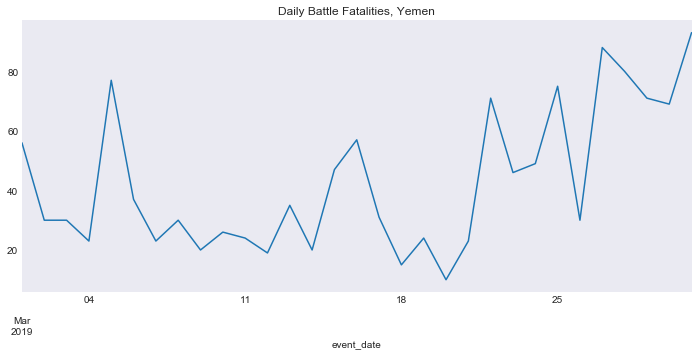

In [271]:
fatalities_ser.plot(figsize=(12,5), title="Daily Battle Fatalities, Yemen");

## Mexican Crime Statistics

The Mexican Government publishes crime reports